In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from IPython.display import clear_output

import sys
sys.path.append('../..')

from vae import VAEModel, compute_fid_score
from rbm import RBM
from dbn import DBN
from load_data import load_mnist

# Load data

In [2]:
X_train, y_train, X_test, y_test = load_mnist(binarize=True)

# VAE - Image Generation

In [ ]:
PATH = './vae_fid_scores.pkl'

def load_dict(path=PATH):
    with open(path, 'rb') as handle:
        d = pickle.load(handle)
    return d

def save_dict(d, path=PATH):
    with open(path, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### Load and sort the dictionary of results ###

dict_results = load_dict()
sorted_values = sorted(dict_results.items(), key=lambda item: item[1])  # Sort by the second element (value)
dict_results = dict(sorted_values)

In [ ]:
best_parameters = list(dict_results.keys())[0]
beta = float(best_parameters.split(',')[0])
latent_dim = int(best_parameters.split(',')[1])
alpha_lrelu = float(best_parameters.split(',')[2])
print(f'Beta: {beta}, latent dimension: {latent_dim}, leaky_relu scope: {alpha_lrelu}')

Beta: 0.01, latent dimension: 2, leaky_relu scope: 0.2


In [ ]:
vae_model = VAEModel(latent_dim=latent_dim, beta=beta, alpha_lrelu=alpha_lrelu)

In [ ]:
nb_params_vae = 0
for param in vae_model.parameters():
    nb_params_vae += np.prod(param.size())

print(f"Nb parameters for VAE: {nb_params_vae:,}")

Nb parameters for VAE: 1,068,820


Epoch 0: error = 218.2041
Epoch 10: error = 146.3161
Epoch 20: error = 139.1605
Epoch 30: error = 135.8139
Epoch 40: error = 133.6569
Epoch 50: error = 132.1349
Epoch 60: error = 131.0639
Epoch 70: error = 130.3629
Epoch 80: error = 128.1853
Epoch 90: error = 128.1014
Epoch 100: error = 127.3162
Epoch 110: error = 127.0641
Epoch 120: error = 126.3319
Epoch 130: error = 125.5891
Epoch 140: error = 125.6969
Epoch 150: error = 125.0769
Epoch 160: error = 124.3038
Epoch 170: error = 126.088
Epoch 180: error = 123.5145
Epoch 190: error = 123.3871
Epoch 200: error = 124.4043
Epoch 210: error = 123.4242
Epoch 220: error = 122.3895
Epoch 230: error = 123.1662
Epoch 240: error = 124.7348
Epoch 250: error = 121.8767
Epoch 260: error = 121.7791
Epoch 270: error = 121.4475
Epoch 280: error = 122.4488
Epoch 290: error = 123.9958
Epoch 300: error = 120.7931
Epoch 310: error = 120.8919
Epoch 320: error = 121.7709
Epoch 330: error = 122.2282
##### PATIENCE TRIGGERED!
Epoch 339: error = 122.2075


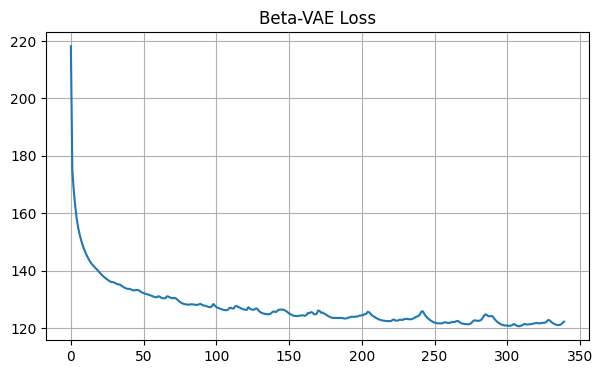

In [ ]:
_ = vae_model.train_vae(X_train, 1000, learning_rate=3e-4, batch_size=256, print_error_every=10, patience=30)

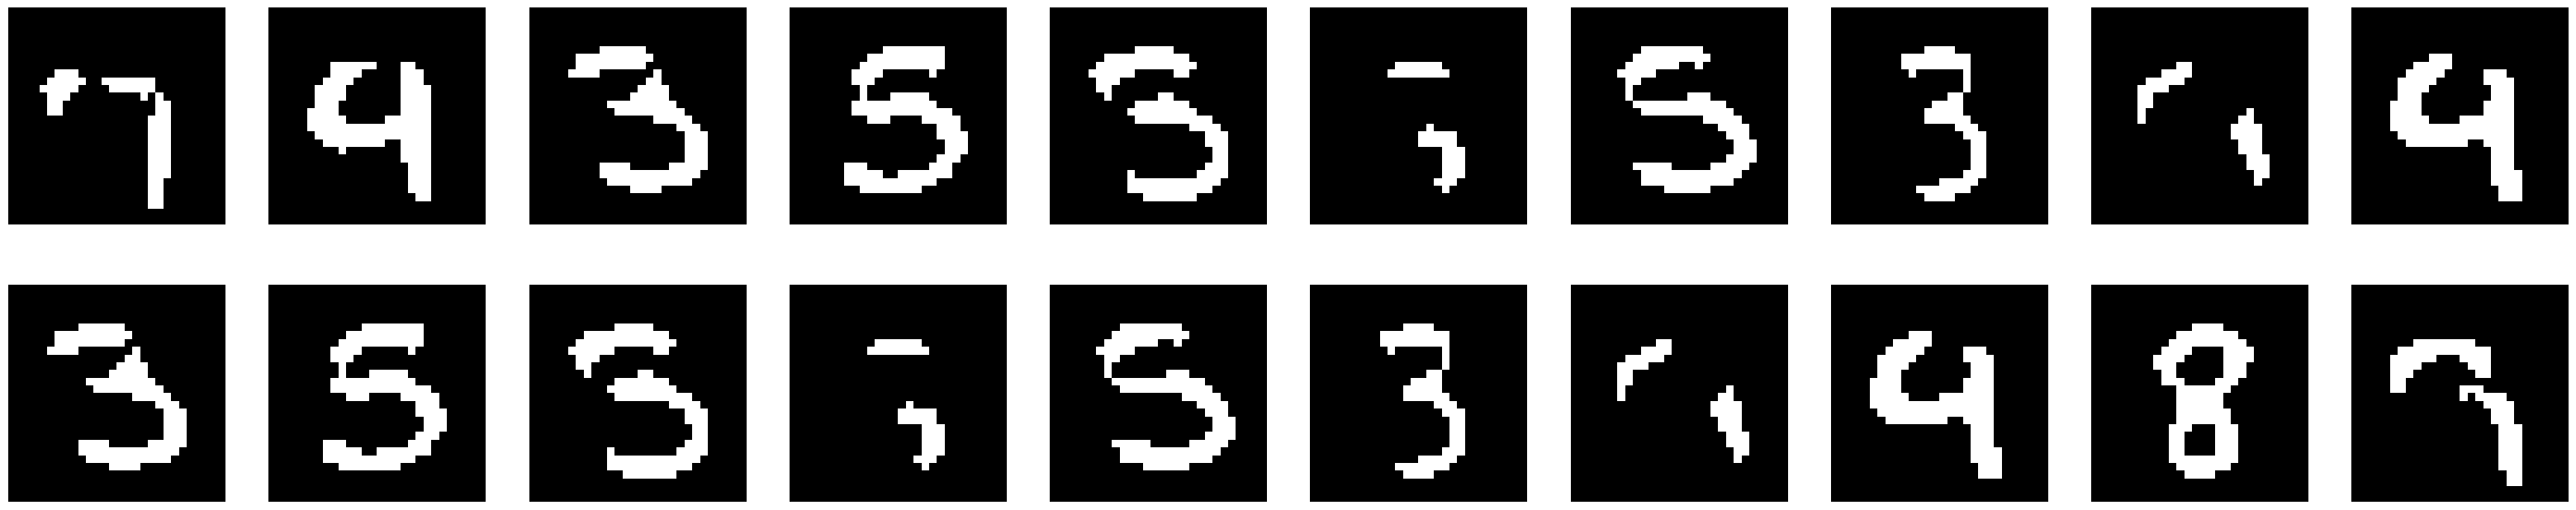

In [ ]:
vae_gen = vae_model.generate_data()

In [ ]:
vae_fid_score = vae_model.compute_fid_score(X_test)
print(f"FID score with VAE: {vae_fid_score:.4f}")

KeyboardInterrupt: 

# DBN

In [3]:
def compute_params_rbm(rbm):
    return rbm.a.shape[0] + rbm.b.shape[0] + np.prod(rbm.W.shape)

In [4]:
dbn_model = DBN(X=X_train, L=5, qs=[128, 512, 784, 512, 256], use_adam=True)

In [5]:
nb_params_dbn = 0
for rbm in dbn_model.rbms:
    nb_params_dbn += compute_params_rbm(rbm)

print(f"nb parameters for DBN: {nb_params_dbn:,}")

nb parameters for DBN: 1,104,688


In [6]:
dbn_model.train_DBN(epochs=300, learning_rate=3e-4, batch_size=128, print_error_every=10)

RBM 2:  40%|████      | 2/5 [1:02:02<1:24:23, 1687.79s/rbm, total_loss=0.128]

Epoch 0: error = 0.1302
Epoch 10: error = 0.075
Epoch 20: error = 0.0707
Epoch 30: error = 0.0691
Epoch 40: error = 0.0681
Epoch 50: error = 0.0675
Epoch 60: error = 0.067
Epoch 70: error = 0.0666
Epoch 80: error = 0.0663
Epoch 90: error = 0.066
Epoch 100: error = 0.0659
Epoch 110: error = 0.0657
Epoch 120: error = 0.0655
Epoch 130: error = 0.0654
Epoch 140: error = 0.0653
Epoch 150: error = 0.0652
Epoch 160: error = 0.0651
Epoch 170: error = 0.065
Epoch 180: error = 0.0649
Epoch 190: error = 0.0649
Epoch 200: error = 0.0648
Epoch 210: error = 0.0648
Epoch 220: error = 0.0647
Epoch 230: error = 0.0647
Epoch 240: error = 0.0646
Epoch 250: error = 0.0646


In [ ]:
_ = dbn_model.generer_image_DBN(num_samples=20, gibbs_steps=1000, ncols=10, image_size=(28, 28))

In [ ]:
dbn_generated_images = dbn_model.generer_image_DBN(num_samples=len(X_test), gibbs_steps=1000, plot_=False)
dbn_fid_score = compute_fid_score(X_test, dbn_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with DBN: {dbn_fid_score:.4f}")

In [ ]:
dbn_model.save_weights(path='./dbn_cmp_vae')

# RBM

In [21]:
rbm_model = RBM(X=X_train, q=784+512+128, use_adam=True)

nb_params_rbm = compute_params_rbm(rbm_model)
print(f"nb parameters for RBM: {nb_params_rbm:,}")

nb parameters for RBM: 1,118,624


Epoch 0: error = 0.1111
Epoch 10: error = 0.0353
Epoch 20: error = 0.0277
Epoch 30: error = 0.0239
Epoch 40: error = 0.0216
Epoch 50: error = 0.0201
Epoch 60: error = 0.019
Epoch 70: error = 0.0181
Epoch 80: error = 0.0173
Epoch 90: error = 0.0167
Epoch 100: error = 0.0161
Epoch 110: error = 0.0156
Epoch 120: error = 0.0151
Epoch 130: error = 0.0147
Epoch 140: error = 0.0143
Epoch 150: error = 0.0139
Epoch 160: error = 0.0135
Epoch 170: error = 0.0132
Epoch 180: error = 0.0129
Epoch 190: error = 0.0126
Epoch 200: error = 0.0123
Epoch 210: error = 0.0121
Epoch 220: error = 0.0118
Epoch 230: error = 0.0116
Epoch 240: error = 0.0113
Epoch 250: error = 0.0111
Epoch 260: error = 0.0109
Epoch 270: error = 0.0106
Epoch 280: error = 0.0104
Epoch 290: error = 0.0102
Epoch 299: error = 0.0101


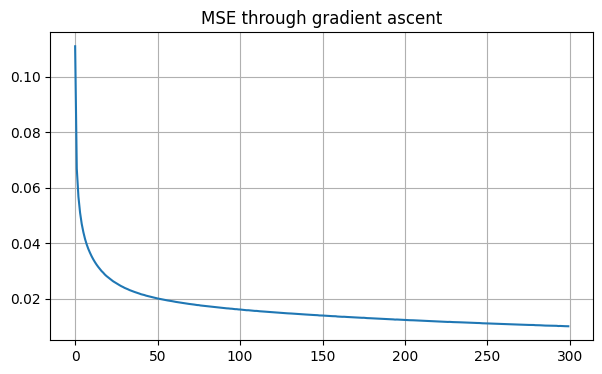

In [22]:
_ = rbm_model.train_RBM(300, learning_rate=3e-4, batch_size=256, plot_errors=True, print_error_every=10)

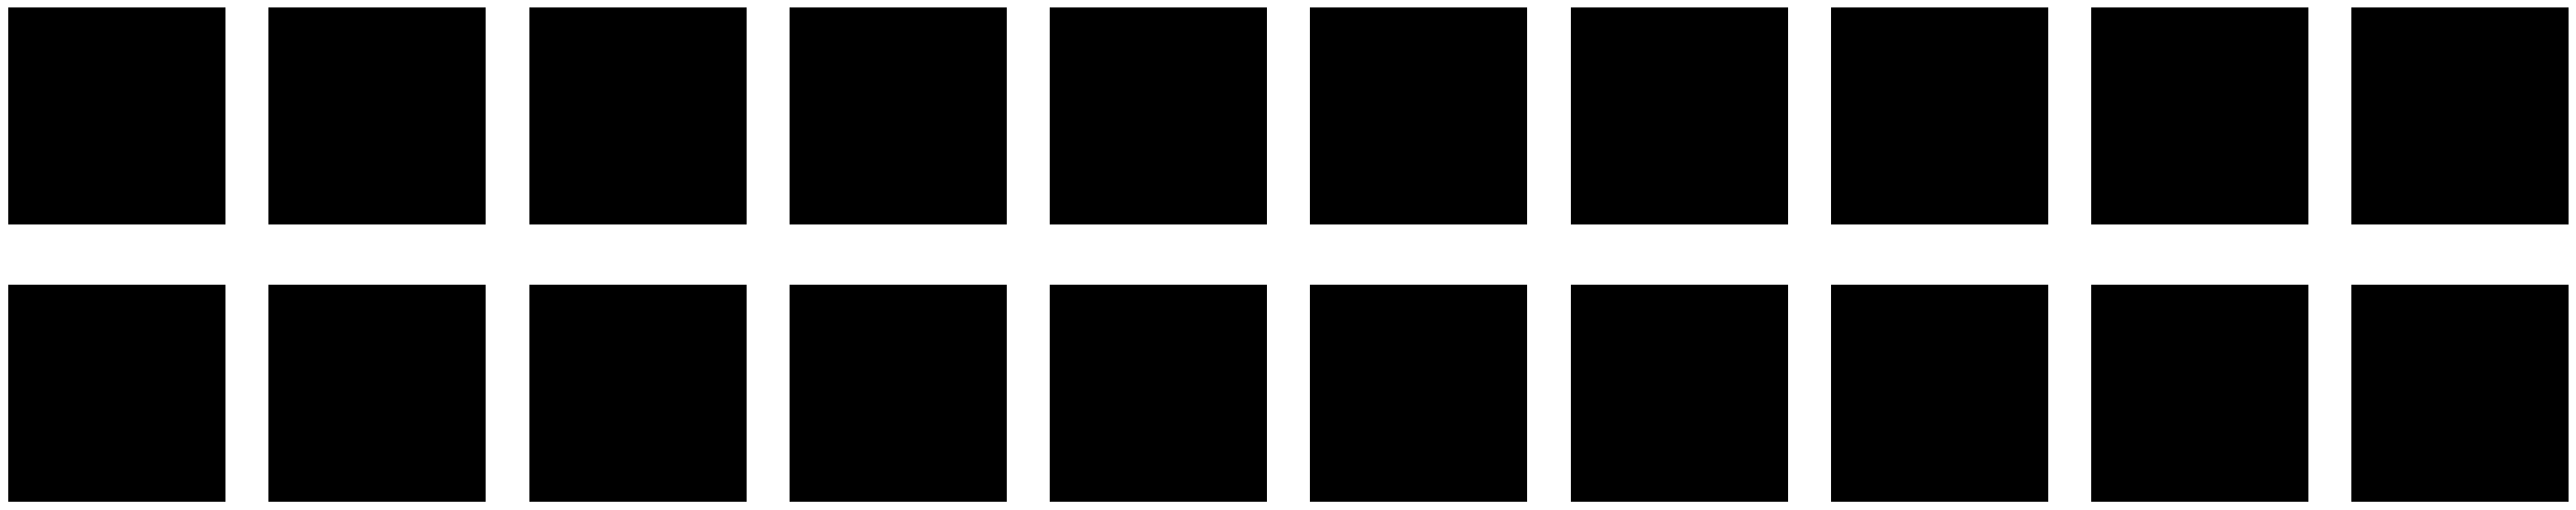

In [23]:
_ = rbm_model.generer_image_RBM(nb_step_gibbs=1000, nb_to_generate=20, ncols=10, image_size=(28, 28))

In [ ]:
rbm_generated_images = rbm_model.generer_image_RBM(nb_step_gibbs=1000, nb_to_generate=len(X_test), ncols=10, plot_=False)
rbm_fid_score = compute_fid_score(X_test, rbm_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with RBM: {rbm_fid_score:.4f}")

In [28]:
rbm_model.save_weights(path='./rbm_cmp_vae')